In [1]:
import os, sys
sys.path.append("..")

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import torch
import torch.nn as nn
import gc

from src import distributions
import torch.nn.functional as F

from IPython.display import clear_output

from src import distributions

from src.plotters import plot_generated_2D, plot_bar_and_stochastic_2D

from tqdm.notebook import tqdm as tqdm

In [2]:
DEVICE_IDS = [0]

G_ITERS = 1
D_ITERS = 1
f_ITERS = 100
D_LR, G_LR, f_LR = 1e-4, 1e-4, 1e-4

ZD = 1
Z_STD = 0.1

BATCH_SIZE = 10000

PLOT_INTERVAL = 100
MAX_STEPS = 10001
SEED = 0x000000
GAMMA = 0.1


DIM = 2

assert torch.cuda.is_available()
torch.cuda.set_device(DEVICE_IDS[0])
torch.manual_seed(SEED)
np.random.seed(SEED)

In [3]:
X_sampler = distributions.StandardNormalSampler(dim=DIM)
Y_sampler = distributions.StandardNormalScaler(distributions.SwissRollSampler()) # <-- Swiss Roll
# Y_sampler = distributions.StandardNormalScaler(distributions.Mix8GaussiansSampler(std=1)) # <-- 8 Gaussians

In [4]:
def weights_init_mlp(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')

H = 100

G = nn.Sequential(
    nn.Linear(DIM+ZD, H),
    nn.ReLU(True), 
    nn.Linear(H, H),
    nn.ReLU(True),
    nn.Linear(H, H),
    nn.ReLU(True),
    nn.Linear(H, DIM)
).cuda()

D = nn.Sequential(
    nn.Linear(DIM, H),
    nn.ReLU(True),
    nn.Linear(H, H),
    nn.ReLU(True),
    nn.Linear(H, H),
    nn.ReLU(True),
    nn.Linear(H, 1)
).cuda()

f = nn.Sequential(
    nn.Linear(DIM+1, H), 
    nn.ReLU(),
    nn.Linear(H, H), 
    nn.ReLU(),
    nn.Linear(H, H), 
    nn.ReLU(),
    nn.Linear(H, DIM)
).cuda()

G.apply(weights_init_mlp); D.apply(weights_init_mlp), f.apply(weights_init_mlp)

print('G params:', np.sum([np.prod(p.shape) for p in G.parameters()]))
print('D params:', np.sum([np.prod(p.shape) for p in D.parameters()]))
print('f params:', np.sum([np.prod(p.shape) for p in f.parameters()]))

G params: 20802
D params: 20601
f params: 20802


In [5]:
G_opt = torch.optim.Adam(G.parameters(), lr=G_LR, weight_decay=1e-10)
D_opt = torch.optim.Adam(D.parameters(), lr=D_LR, weight_decay=1e-10)
f_opt = torch.optim.Adam(f.parameters(), lr=f_LR, weight_decay=1e-10)

Step 0
Plotting
(DOT map appears only on the last step)


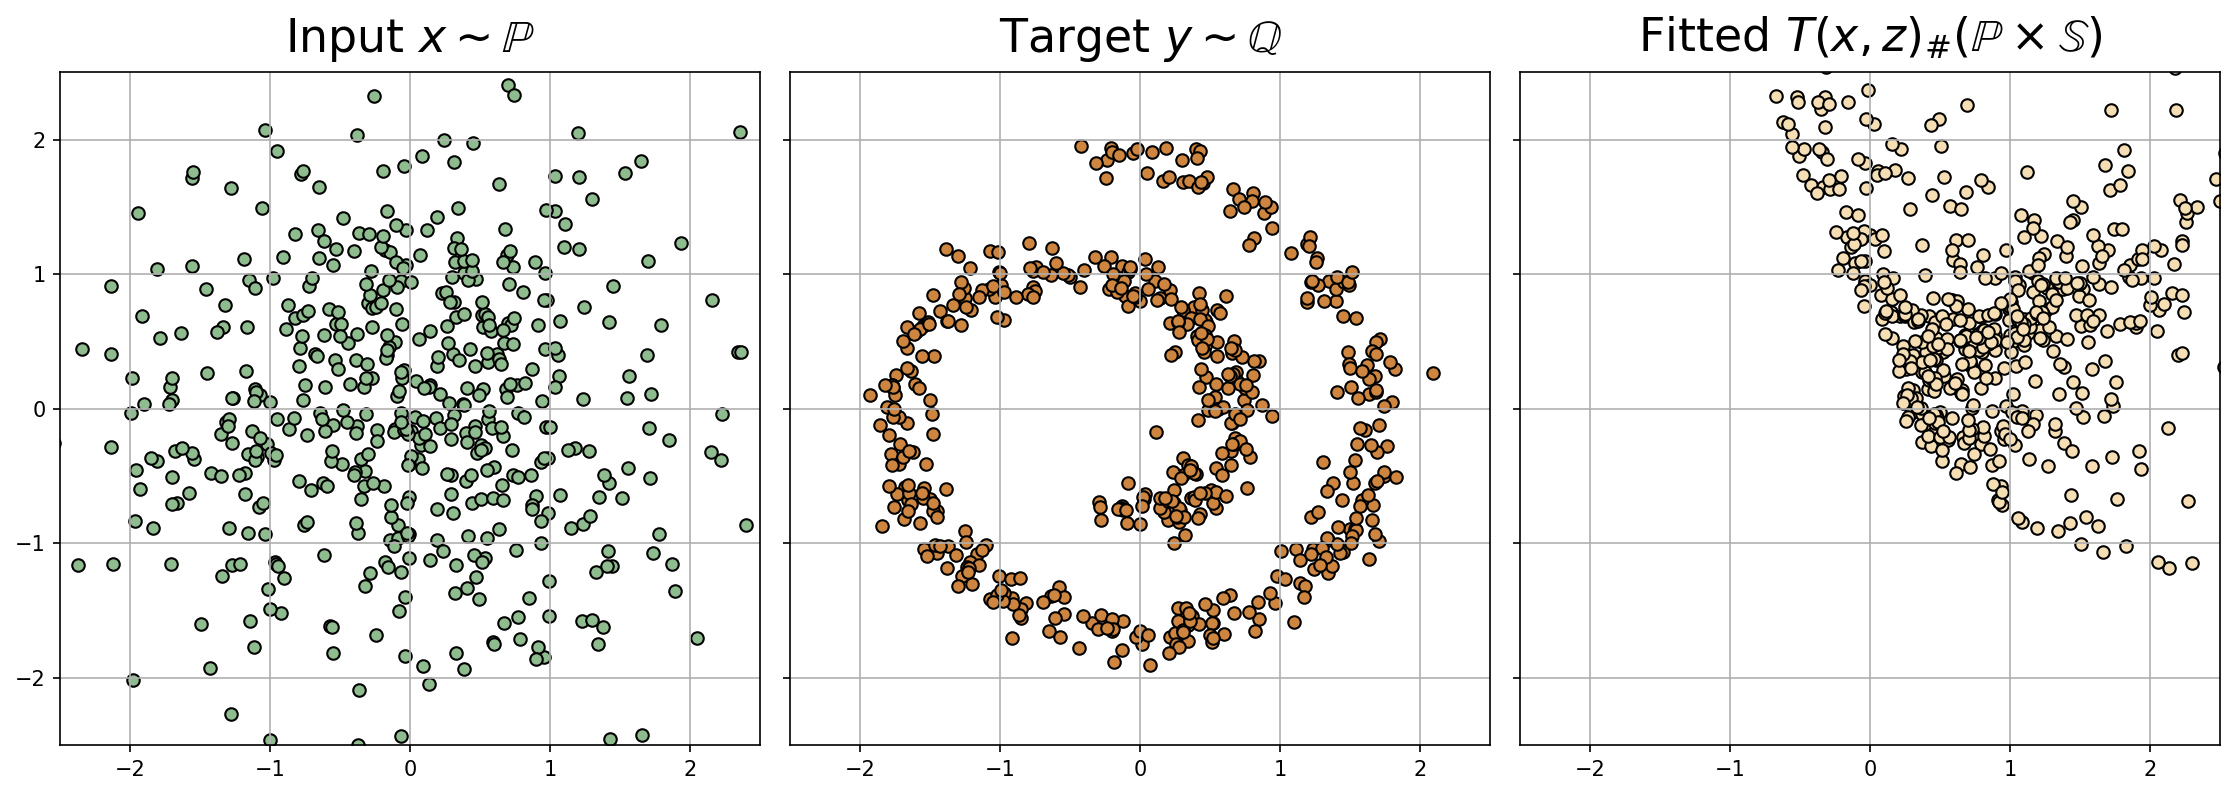

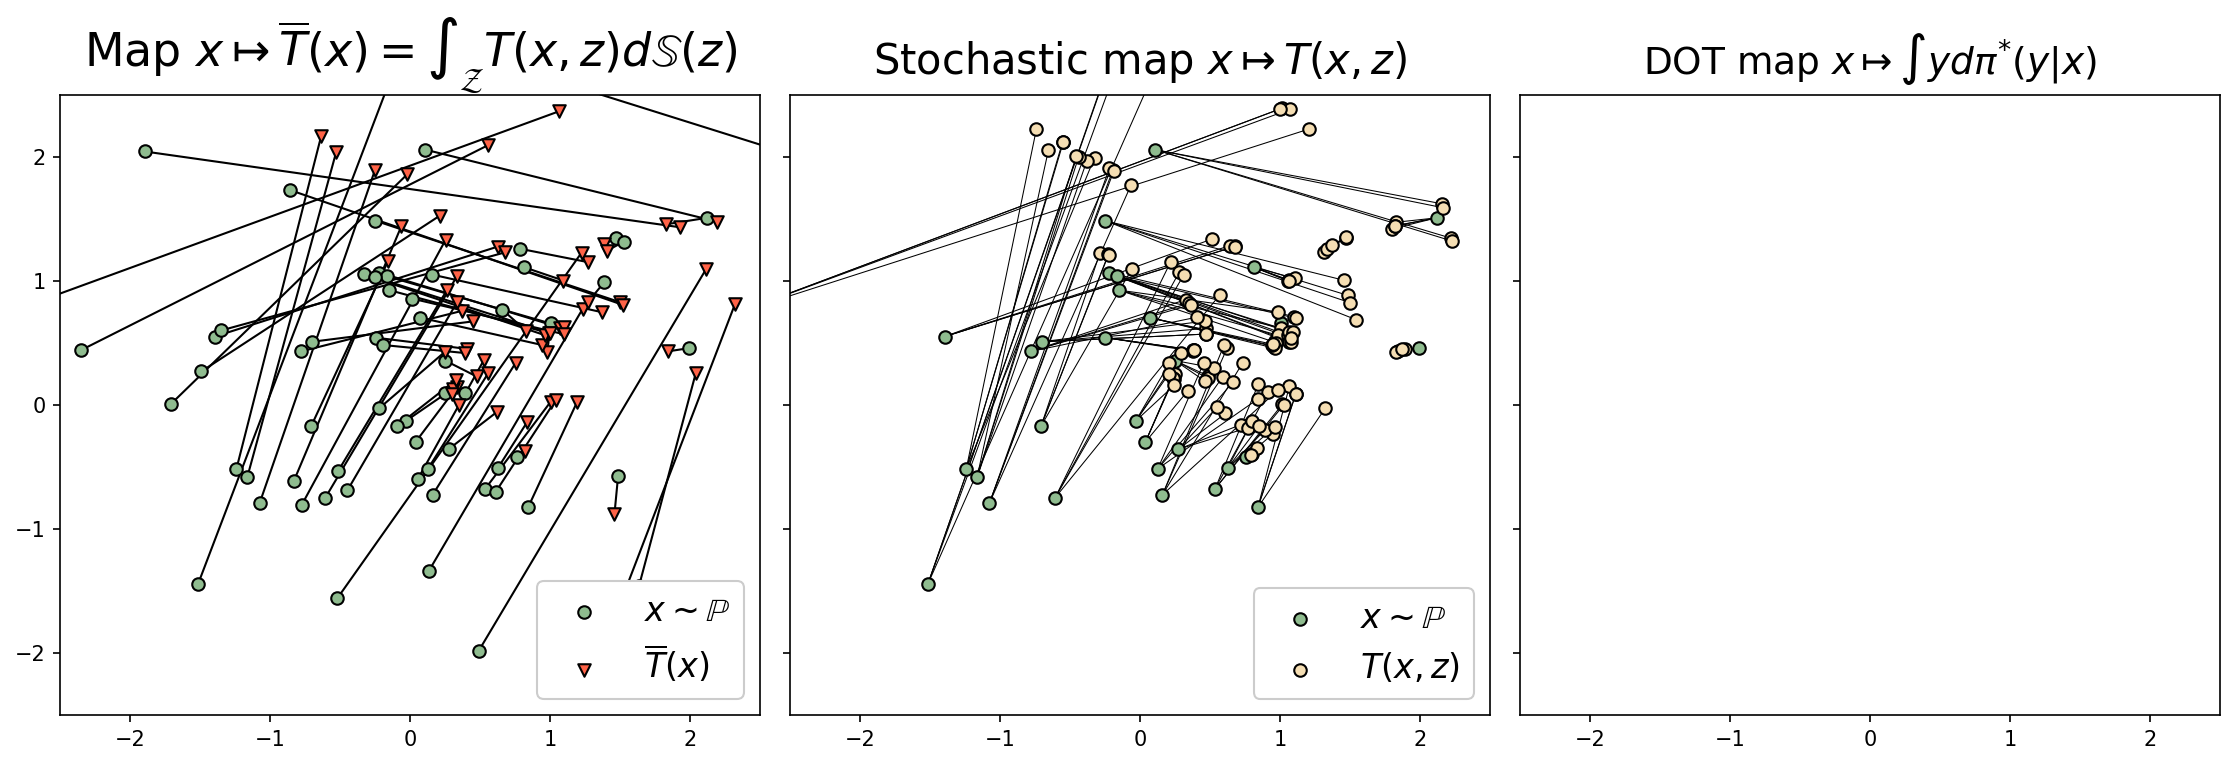

tensor(1.5715, device='cuda:0', grad_fn=<MeanBackward0>)
f_integral: 1.155739426612854
mse: 1.7581971883773804
tensor(1.3572, device='cuda:0', grad_fn=<MeanBackward0>)
f_integral: 1.2833492755889893
mse: 1.8766613006591797
tensor(1.7908, device='cuda:0', grad_fn=<MeanBackward0>)
f_integral: 1.3644497394561768
mse: 1.9244681596755981
tensor(1.5207, device='cuda:0', grad_fn=<MeanBackward0>)
f_integral: 1.4314030408859253
mse: 2.082714796066284
tensor(1.2536, device='cuda:0', grad_fn=<MeanBackward0>)
f_integral: 1.4991676807403564
mse: 2.0898706912994385
tensor(1.2576, device='cuda:0', grad_fn=<MeanBackward0>)
f_integral: 1.6462862491607666
mse: 2.1830852031707764
tensor(1.7004, device='cuda:0', grad_fn=<MeanBackward0>)
f_integral: 1.6852704286575317
mse: 2.278712749481201
tensor(1.4299, device='cuda:0', grad_fn=<MeanBackward0>)
f_integral: 1.751221776008606
mse: 2.368300199508667
tensor(1.3980, device='cuda:0', grad_fn=<MeanBackward0>)
f_integral: 1.8273266553878784
mse: 2.39466381072998

KeyboardInterrupt: 

In [6]:
for step in tqdm(range(MAX_STEPS)):


    for f_iter in range(f_ITERS):
        X_0 = X_sampler.sample(BATCH_SIZE)
        Z = torch.randn(BATCH_SIZE, ZD, device='cuda') * Z_STD
        X_1 = G(torch.cat([X_0, Z], dim=1))
        t = torch.rand(X_0.shape[0], device=X_0.device)[:, None]
        X_t = X_0 + (X_1 - X_0) * t + torch.randn_like(X_0)*torch.sqrt(t*(1-t)*GAMMA)
        
        f_loss = ((f(torch.cat((X_t, t), dim =-1)) - (X_1 - X_t)/(1-t)) ** 2).mean()
        f_opt.zero_grad(); f_loss.backward(); f_opt.step()

    print(f_loss)


    for t_iter in range(G_ITERS):
        X = X_sampler.sample(BATCH_SIZE)
        Z = torch.randn(BATCH_SIZE, ZD, device='cuda') * Z_STD
        G_X = G(torch.cat([X, Z], dim=1))

        t = torch.rand(X.shape[0], device=X.device)[:, None]
        X_t = X + (G_X - X) * t + torch.randn_like(X)*torch.sqrt(t*(1-t)*GAMMA)
        f_x_t = f(torch.cat((X_t, t), dim =-1))
        f_integral = (f_x_t**2).mean(axis=1)
        

        # G_loss = f_integral.mean()
        G_loss = f_integral.mean() - D(G_X).mean()

        # G_loss = F.mse_loss(X, G_X).mean()
        # G_loss = F.mse_loss(X, G_X).mean() - D(G_X).mean()
        G_opt.zero_grad(); G_loss.backward(); G_opt.step()

    print('f_integral:', f_integral.mean().item())
    print('mse:', F.mse_loss(X, G_X).mean().item())


    for d_iter in range(D_ITERS):
        X = X_sampler.sample(BATCH_SIZE)
        Z = torch.randn(BATCH_SIZE, ZD, device='cuda') * Z_STD
        G_X = G(torch.cat([X, Z], dim=1))
        Y = Y_sampler.sample(BATCH_SIZE)
        D_loss = D(G_X).mean() - D(Y).mean()
        D_opt.zero_grad(); D_loss.backward(); D_opt.step()


    if step % PLOT_INTERVAL == 0:
        clear_output(wait=True)
        print("Step", step)
        print("Plotting")
        print("(DOT map appears only on the last step)")

        fig, axes = plot_generated_2D(X_sampler, Y_sampler, G, ZD, Z_STD)
        plt.show()
        
        fig, axes = plot_bar_and_stochastic_2D(
            X_sampler, Y_sampler, G, ZD, Z_STD,
            plot_discrete=True if step == MAX_STEPS-1 else False)
        plt.show()
        
        for p in G.parameters():
            p.requires_grad_(True)
        for p in D.parameters():
            p.requires_grad_(True)
        for p in f.parameters():
            p.requires_grad_(True)